<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Unsupervised Analysis Project</h2><br>
<h4>DAT-5329 | Introduction to Machine Learning & AI (March, 2024)</h4><br>
Author: <a href="https://www.linkedin.com/in/cla-wiese/" target="_blank">Constantin L. A. Wiese</a><br><br>
Hult International Business School<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3>Introduction</h3><br>
This analysis aims to explore the dynamics of social media engagement within the specific context of Thailand's market, emphasizing the comparative impact of video content against traditional social media content forms. Leveraging a dataset comprising 2,297 Facebook posts by Thai fashion and cosmetics retailers collected via the Facebook API, the study employs unsupervised learning techniques, such as Principal Component Analysis (PCA), to uncover latent patterns and relationships indicative of user engagement levels. Central to this investigation is the hypothesis that video content, especially live streaming, significantly surpasses other content forms in engaging users, as evidenced by quantitative metrics, including likes, shares, comments, and various emoji reactions. Through a rigorous statistical examination of these engagement metrics, the research seeks to provide empirical insights into the efficacy of different types of social media content in fostering user interaction. This inquiry is poised to contribute valuable perspectives to strategically optimizing content to enhance engagement on social media platforms within Thailand's burgeoning digital landscape.

<h3>Data Preparation</h3>

In [1]:
# Standard packages
import matplotlib.pyplot as plt   # data visualization
import numpy as np                # mathematical essentials
import pandas as pd               # data science essentials
import seaborn as sns             # enhanced data viz
import sys                        # system-specific parameters and functions
import warnings                   # suppressing warnings

# Packages for unsupervised learning
from sklearn.decomposition   import PCA                 # pca
from scipy.cluster.hierarchy import dendrogram, linkage # dendrograms
from sklearn.cluster         import KMeans              # k-means clustering

# Preprocessing and model selection libraries
from sklearn.model_selection import RandomizedSearchCV  # hyperparameters
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.preprocessing import StandardScaler        # standard scaler

# Model evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Machine learning models
from sklearn.linear_model import LogisticRegression     # logistic

# suppressing warnings
warnings.filterwarnings("ignore")

In [2]:
# setting pandas print options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 100)
np.set_printoptions(threshold = sys.maxsize)

# specifying file paths
path = "./datasets/facebook_live_data.xlsx"

# calling data
df = pd.read_excel(io              = path,
                   header          = 0,
                   index_col       = "status_id",
                   keep_default_na = True)

print(f"""Dataset Size
-------------------
Observations: {df.shape[0]}
Features:     {df.shape[1]}
""")           # formatting and printing the dimensions of the dataset
df.head(n = 4) # checking results

Dataset Size
-------------------
Observations: 2297
Features:     10



,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
status_id,,,,,,,,,,
1,video,2018-04-22 06:00:00,512,262,432,92,3,1,1,0
2,photo,2018-04-18 03:22:00,0,0,204,9,0,0,0,0
3,video,2018-04-18 00:24:00,614,72,418,70,10,2,0,3
4,photo,2018-04-11 04:53:00,9,1,167,3,0,0,0,0


2,297 observations with ten features were loaded, and the overview below shows that no missing value imputation is necessary. Furthermore, only status_type and time_published must not be taken into account in the principal component analysis.

In [3]:
df.info(verbose = True) # checking information about each feature

<class 'pandas.core.frame.DataFrame'>
Index: 2297 entries, 1 to 2297
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_type     2297 non-null   object        
 1   time_published  2297 non-null   datetime64[ns]
 2   num_comments    2297 non-null   int64         
 3   num_shares      2297 non-null   int64         
 4   num_likes       2297 non-null   int64         
 5   num_loves       2297 non-null   int64         
 6   num_wows        2297 non-null   int64         
 7   num_hahas       2297 non-null   int64         
 8   num_sads        2297 non-null   int64         
 9   num_angrys      2297 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 197.4+ KB


The time data must be transformed to make it suitable for modeling. Any time data that could be of use later is removed.

In [4]:
# extract desired components
df["year"] = df["time_published"].dt.year               # year
df["month"] = df["time_published"].dt.month             # month
df["week"] = df["time_published"].dt.isocalendar().week.astype("int32") # week
df["day"] = df["time_published"].dt.day                 # day (1 to 31)
df["weekday"] = df["time_published"].dt.weekday         # Monday=0, ... to Sunday=6
df["hour"] = df["time_published"].dt.hour               # hour (0-23)
df["minute"] = df["time_published"].dt.minute           # likely too narrow

# Creating binary variables for each time of day
df["night"] = df["hour"].apply(lambda x: 1 if 0 <= x < 6 else 0)
df["morning"] = df["hour"].apply(lambda x: 1 if 6 <= x < 12 else 0)
df["afternoon"] = df["hour"].apply(lambda x: 1 if 12 <= x < 18 else 0)
df["evening"] = df["hour"].apply(lambda x: 1 if 18 <= x < 24 else 0)

# Define the cutoff date when emoticon reactions were introduced
cutoff_date = pd.to_datetime("2016-02-29")

# Creating a dummy variable
df["emoticons"] = (df["time_published"] > cutoff_date).astype(int)

In [5]:
# Checking Representation of distribution - is n > 30?
times = ["year", "month", "week", "day", "weekday", "hour", "minute",
         "night", "morning", "afternoon", "evening", "emoticons"]
for col in times: # iterating over each time feature
    counts = df[col].value_counts().sort_index() # creating and printing data
    print(f"{col.capitalize()} Counts:\n{counts.to_string(header = False)}\n")

Year Counts:
2012    183
2013    153
2014     74
2015    109
2016    231
2017    702
2018    845

Month Counts:
1     207
2     180
3     211
4     194
5     229
6     192
7     115
8     152
9     169
10    179
11    215
12    254

Week Counts:
1     44
2     57
3     33
4     55
5     47
6     40
7     46
8     44
9     46
10    45
11    52
12    58
13    42
14    60
15    38
16    41
17    43
18    42
19    41
20    37
21    70
22    73
23    89
24    40
25    20
26    13
27    17
28    19
29    43
30    31
31    34
32    37
33    34
34    33
35    37
36    31
37    30
38    46
39    45
40    23
41    40
42    53
43    45
44    41
45    35
46    58
47    66
48    60
49    57
50    52
51    64
52    47
53     3

Day Counts:
1     64
2     76
3     78
4     78
5     89
6     73
7     65
8     85
9     81
10    76
11    90
12    74
13    65
14    50
15    71
16    74
17    63
18    79
19    69
20    86
21    74
22    86
23    83
24    95
25    88
26    75
27    80
28    64
29    79
30 

The temporal distribution of data reveals a discernible trend over the years, with a marked increase in activity from 2012 through 2018, peaking in the latter years. Monthly and weekly analyses indicate a relatively consistent engagement across the board, with notable spikes in December and during the 21st to 23rd weeks of the year. Daily engagement shows a preference for posting in the month's latter half, particularly on the 24th. Analysis of postings by weekday demonstrates a relatively even distribution, with a slight preference for posting towards the end of the week. Hourly data highlights a significant inclination towards nighttime and early morning postings, sharply decreasing during the late morning to early afternoon hours. These patterns suggest strategic content release timing to maximize viewer engagement and interaction.

<h3>Video Content vs. Other Media: A Comparative Analysis of Engagement</h3>

In [6]:
# value counts for status_type
print(f"""\
Status Type
-------
{df["status_type"].value_counts(normalize = False).to_string(header = False)}
""")

df.describe(include=[np.number]).round(decimals = 2).iloc[1:,:] # statistics 

Status Type
-------
photo    1385
video     778
text      134



,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,month,week,day,weekday,hour,minute,night,morning,afternoon,evening,emoticons
mean,205.16,39.12,221.76,13.05,1.49,0.63,0.25,0.10,2016.41,6.54,26.55,15.73,3.00,7.87,28.06,0.43,0.38,0.02,0.16,0.76
std,775.25,125.64,446.51,40.30,10.15,2.91,1.73,0.55,1.91,3.61,15.75,8.75,2.03,7.04,17.67,0.50,0.49,0.14,0.37,0.43
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2012.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,18.00,0.00,0.00,0.00,0.00,0.00,2016.00,3.00,13.00,8.00,1.00,2.00,12.00,0.00,0.00,0.00,0.00,1.00
50%,4.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,2017.00,6.00,24.00,16.00,3.00,7.00,27.00,0.00,0.00,0.00,0.00,1.00
75%,24.00,5.00,195.00,3.00,1.00,0.00,0.00,0.00,2018.00,10.00,42.00,23.00,5.00,9.00,43.00,1.00,1.00,0.00,0.00,1.00
max,19013.00,2139.00,4710.00,504.00,252.00,91.00,51.00,12.00,2018.00,12.00,53.00,31.00,6.00,23.00,59.00,1.00,1.00,1.00,1.00,1.00


The dataset contains 1,385 photos, 778 videos, and 134 text posts, indicating a higher prevalence of photo content than videos and text. The dataset's engagement metrics, such as comments, shares, and likes, exhibit substantial variability, with mean values suggesting moderate engagement but with extremes ranging from no interaction to very high levels, highlighted by the significant differences between the 75th percentile and maximum values.

In [7]:
# specifying engagement features
engagement = ["num_comments", "num_shares", "num_likes", "num_loves",
              "num_wows", "num_hahas", "num_sads", "num_angrys"]

# Adding a feature for total engagement which is the sum of all reactions
df["engagement"] = df[engagement].sum(axis = 1)

# Grouping data by status_type and calculating mean and median for metrics
aggregated_df = df.groupby("status_type")[engagement + ["engagement"]]\
                .agg(["median", "mean"]).round(decimals = 2)

# Display the aggregated data for analysis
aggregated_df

num_comments         num_shares         num_likes         num_loves        num_wows       num_hahas       num_sads       num_angrys       engagement        
                  median    mean     median    mean    median    mean    median   mean   median  mean    median  mean   median  mean     median  mean     median    mean
status_type                                                                                                                                                             
photo                3.0   13.07        0.0    2.27      39.0  194.11       0.0   1.43      0.0  0.69       0.0  0.17      0.0  0.14        0.0  0.02       45.0  211.90
text                10.0   38.12        0.0    2.47     122.5  442.37       0.0   1.97      0.0  1.40       0.0  0.10      0.0  0.25        0.0  0.04      146.0  486.72
video               36.0  575.89       11.0  111.02     117.5  232.99       3.0  35.63      0.0  2.94       0.0  1.52      0.0  0.44        0.0  0.25      430.5  960.67

Analyzing the provided data reveals significant insights into how different types of content on social media - photos, text, and videos - engage audiences. Notably, videos stand out for their superior performance.

Firstly, when considering the median number of comments, videos dramatically outperform photos and text, with videos receiving a median of 36 comments compared to 10 for text and just 3 for photos, which suggests that videos are more likely to prompt discussions or reactions that lead to commenting, indicating higher viewer engagement.

A similar trend is evident within shares. Videos have a significantly higher median number of shares (11) compared to photos and text, which have a median of 0 shares. This discrepancy highlights the viral potential of video content, which is more likely to be shared among users, further amplifying its reach and engagement.

Regarding likes, a basic form of engagement, text leads with a higher mean (442.37) in comparison to videos (232.99). However, this discrepancy diminishes when considering the median number of videos (117.5) to text (122.5), indicating a more consistent engagement with video content at the median level despite the higher average for text. This may indicate that a controversial text statement results from time in an outstanding amount of likes.

The love reaction, which conveys a stronger affinity than a simple like, is far more common for videos, with a mean of 35.63, compared to 1.97 for photos and even lower for text, which suggests that videos are more effective in eliciting emotional reactions from the audience.

Videos again lead in mean numbers for other reactions like wows, hahas, sads, and angrys. However, these reactions are less common overall, indicating a broader range of emotional responses elicited by video content, which can engage viewers on multiple emotional levels.

When aggregating all forms of engagement (comments, shares, likes, and reactions), videos demonstrate the highest total median engagement (430.5) and mean engagement (960.67), significantly outstripping photos and text. This composite engagement metric solidifies videos' position as the most engaging content type on social media.

This data underlines a clear trend: videos are the most engaging form of content on social media platforms, outperforming photos and text in almost every engagement metric. Videos' ability to convey messages in a dynamic, visually appealing manner likely contributes to this enhanced engagement, fostering a deeper connection with the audience that prompts more significant interaction.

The substantial difference in engagement metrics between videos and other content types supports the company's initial hypothesis that video content is crucial for maximizing social media engagement. Videos are not only more engaging on average but also have the potential to elicit a broader range of emotional reactions from the audience, making them an indispensable tool in social media marketing strategies.

<h3>PCA Engagement Analysis</h3>

Before executing a PCA analysis, some functions are defined.

In [8]:
# scree_plot #################################################################
def scree_plot(pca_object, cut_off = None, export = False):
    """
    Visualizes a scree plot from a pca object.
    
    PARAMETERS
    ----------
    pca_object | A fitted pca object
    cut_off    | The cumulative variance cutoff to draw a vertical line
    export     | Set to True if you would like to save the scree plot to the
               | current working directory (default: False)
    """
    # setting plot size
    fig, ax = plt.subplots(figsize=(12, 5))
    features = range(pca_object.n_components_)

    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth       = 2,
             marker          = "o",
             markersize      = 10,
             markeredgecolor = "black",
             markerfacecolor = "grey")

    # drawing the cutoff line if specified
    if cut_off is not None:
        # calculate the cumulative variance
        cumulative_variance = pca_object.explained_variance_ratio_.cumsum()
        # find the index where the cumulative variance exceeds the cutoff
        cut_off_index = (cumulative_variance >= cut_off).argmax()
        # draw a vertical line at the cutoff index
        plt.axvline(x         = cut_off_index,
                    color     = "red",
                    linestyle = "--",
                    linewidth = 2)
    
    # setting more plot options
    plt.title("Scree Plot")
    plt.xlabel("PCA feature")
    plt.ylabel("Explained Variance")
    plt.xticks(features)

    if export == True:
        # exporting the plot
        plt.savefig('./images/scree_plot.png')
        
    # displaying the plot
    plt.show()

# standard_scaler ############################################################
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """
    scaler = StandardScaler(copy = True) # instantiating a StandardScaler()
    scaler.fit(df)                       # fitting the scaler with the data
    x_scaled = scaler.transform(df)      # transforming the data after fit
    new_df = pd.DataFrame(x_scaled, index = df.index) # converting to DF
    new_df.columns = df.columns          # reattaching column names
    return new_df

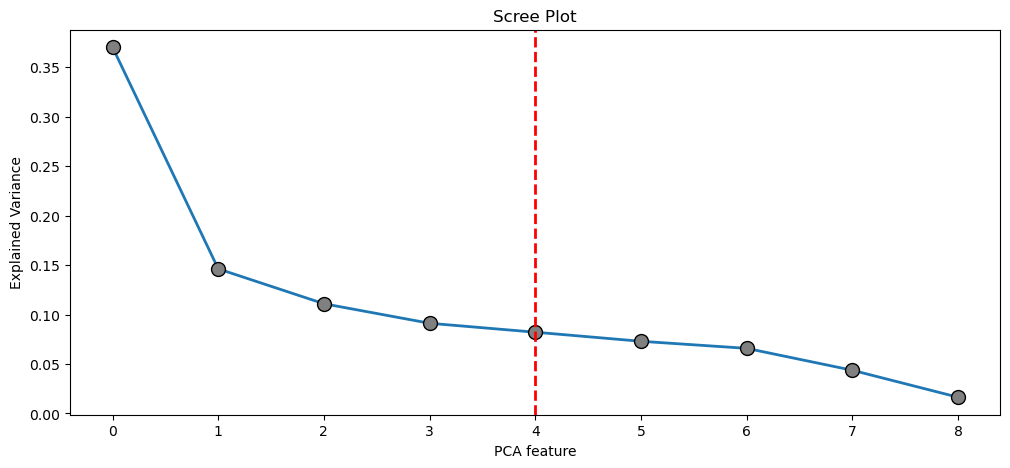

In [9]:
# specifying engagement PCA components
df_engagement = df[["num_comments", "num_shares", "num_likes", "num_loves",
                   "num_wows", "num_hahas", "num_sads", "num_angrys",
                    "emoticons"]]

# applying the standard_scaler function
df_eng_sc = standard_scaler(df = df_engagement)

# instantiating a PCA object with no limit to principal components
pca_eng = PCA(n_components = None,
          random_state = 1836)

# fitting and transforming the scaled data
pca_eng_ft = pca_eng.fit_transform(df_eng_sc)

# calling the scree_plot function with 80% variance explanation cut-off
scree_plot(pca_object = pca_eng, cut_off = 0.8, export = True)

The scree plot analysis suggests a notable elbow at the second principal component, indicating a natural point of inflection in the variance explained by the components of the dataset. However, a retention of the first five principal components is advocated for a more comprehensive encapsulation of the dataset's inherent variance. This decision is underpinned by the cumulative variance explained, with the first component accounting for a considerable 37% of the variance and the subsequent components—up to the fifth—collectively contributing to a cumulative explained variance that is significantly higher. Specifically, the second through fifth components add 14.6%, 11.1%, 9.1%, and 8.2%, respectively, cumulatively crossing the threshold of variance explanation deemed sufficient for the current analytical context. Retaining the fifth component ensures a more nuanced capture of the dataset's structure, adhering to the analytical goal of dimensionality reduction while preserving a robust aggregate of the underlying variance.

In [10]:
# instantiating a PCA object with 5 principal components
pca_eng = PCA(n_components = 5,
          random_state = 1836)

# fitting and transforming the scaled data
pca_eng_ft = pca_eng.fit_transform(df_eng_sc)

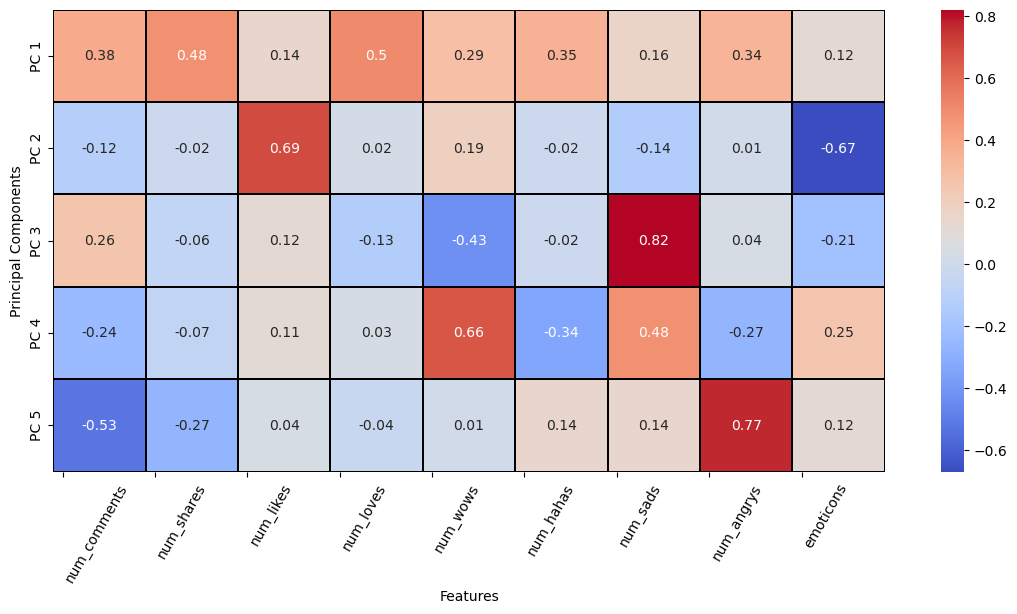

In [11]:
# Round the values to 2 decimals
rounded_values = pca_eng.components_.round(decimals = 2)

# setting plot size
fig, ax = plt.subplots(figsize = (12, 6))

# developing a PC to feature heatmap
sns.heatmap(data       = rounded_values, 
            cmap       = "coolwarm",
            square     = True,
            annot      = True,
            linewidths = 0.1,
            linecolor  = "black")

# setting more plot options
plt.yticks(np.arange(0.5, 5.5, 1),
           ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5"])

plt.xticks(np.arange(0.1, 9.1, 1),
           df_eng_sc.columns,
           rotation = 60,
           ha       = "left")

# setting labels
plt.xlabel(xlabel = "Features")
plt.ylabel(ylabel = "Principal Components")

# displaying the plot
plt.tight_layout()
plt.show()

**PC 1 - Virality**: This component has strong positive correlations across various metrics, particularly `num_shares` and `num_loves`, suggesting it captures the essence of content that is not only liked but also shared and adored, critical indicators of viral potential. The uniform positivity across engagement types implies that this component reflects content that effectively taps into the collective psyche, prompting a holistic interactive experience. It could be related to highly relatable, emotionally charged content or having a universal appeal, thereby resonating with a broad audience. Virality, as the name suggests, is content poised for rapid and widespread dissemination, often accompanied by a strong, positive emotional reaction from the social media populace. This type of content typically spurs users to engage with the material through various expressions and share it, thus amplifying its reach. The absence of negative correlations indicates that such content is uniformly well-received and devoid of polarizing effects.

**PC 2 - Endorsement**: Dominated by `num_likes`, this principal component reflects a dimension of content engagement characterized by passive acknowledgment or simple endorsement. Unlike PC 1, the lack of strong correlations with other engagement types suggests these are posts that users feel comfortable endorsing but not necessarily willing to engage with more deeply. Such content might be visually appealing or generally agreeable, garnering approval without controversy or deep emotional resonance. Endorsement does not typically invoke a strong desire in users to share, comment, or react with more nuanced emotions. It could be content that users passively consume and appreciate without feeling compelled to participate in discussions or share within their networks actively. This type of engagement is common for pleasing content but not thought-provoking or emotionally stirring. The high negative correlation with emoticons showcases that this feature cannot be observed as clearly in posts before March 2016, as simple emoticons were unavailable beforehand. However, the negative correlation with comments showcases its effect nonetheless.

**PC 3 - Compassion**: This component is characterized by a strong positive correlation with `num_sads`, suggesting that it represents user engagement with content that elicits empathy or compassion. The negative correlation with `num_wows` implies these are not typically posts that surprise or shock; instead, they resonate more seriously and emotionally. Compassion indicates content that might address somber topics, social issues, or personal narratives that solicit a compassionate response from the community. The content captured by this component likely fosters a sense of solidarity or shared grief, prompting users to express their condolences or support. This component signifies the ability of content to bring out a collective empathetic response, often associated with posts that might have a social or emotional appeal calling for support or awareness. The content within this Compassion dimension is powerful in its ability to unite users in shared feelings and often facilitates a supportive community response.

**PC 4 - Surprise**: The highest correlation with `num_wows` indicates that this component encapsulates the element of surprise in social media content. The negative correlations with `num_comments` and `num_hahas` suggest that while the content is surprising, it may not encourage extended discourse or comedic engagement. Surprise as a term for this PC implies that the content has an element of the unexpected that captivates and momentarily stuns the audience, including astonishing facts, stunning visuals, or shock reveals that leave an immediate impression but may not lead to further engagement or emotional investment. Content within this domain is likely to be shareable but in a way that communicates the initial surprise rather than ongoing interaction. It captures those singular moments of awe that can momentarily arrest the scrolling eye of a social media user.

**PC 5 - Discord**: This component is characterized by a pronounced negative correlation with `num_comments` and a prominent positive correlation with `num_angrys`, pointing towards content that generates discord among the audience. The strong negative relationship with comments may indicate that while the content prompts a reaction, it possibly discourages open discussion or constructive dialogue, potentially due to its polarizing nature. The significant positive correlation with `num_angrys` underscores that the content will likely incite frustration or disagreement, reflecting posts that could be controversial, unsettling, or provoke a public outcry. Content represented by this principal component typically triggers a confrontational form of engagement, where users are more inclined to express their dissent or outrage rather than engage in a rational discourse. This suggests a kind of engagement where contentious issues galvanize users to express strong negative sentiments.

In [12]:
# converting to a DataFrame
pca_eng_ft = pd.DataFrame(pca_eng_ft, index = df.index)

# renaming columns
pca_eng_ft.columns = ["virality", "endorsement", "compassion", "surprise",
                      "discord"]

pca_eng_ft.head(n = 3) # checking results

,virality,endorsement,compassion,surprise,discord
status_id,,,,,
1,2.201731,-0.133061,-0.058477,0.344792,-0.744549
2,-0.436547,-0.375792,-0.217917,0.174042,0.106731
3,3.309945,0.100473,-0.418299,-1.011466,3.743261


<h3>K-Means Clustering</h3>

In [13]:
# merging principal components with time features
df_prep = pd.concat([pca_eng_ft, df[["year", "month", "week", "day",
                                     "weekday", "hour", "minute", "night",
                                     "morning", "afternoon", "evening"]]],
                    axis = 1)

# scaling data to prepare for K-Means clustering
df_prep_sc = standard_scaler(df_prep)

Before clustering, the engagement components are amalgamated with temporal variables and subsequently scaled to facilitate the k-means algorithm by best practices. Original engagement features are eschewed in this process to ensure optimal algorithmic performance and data integrity.

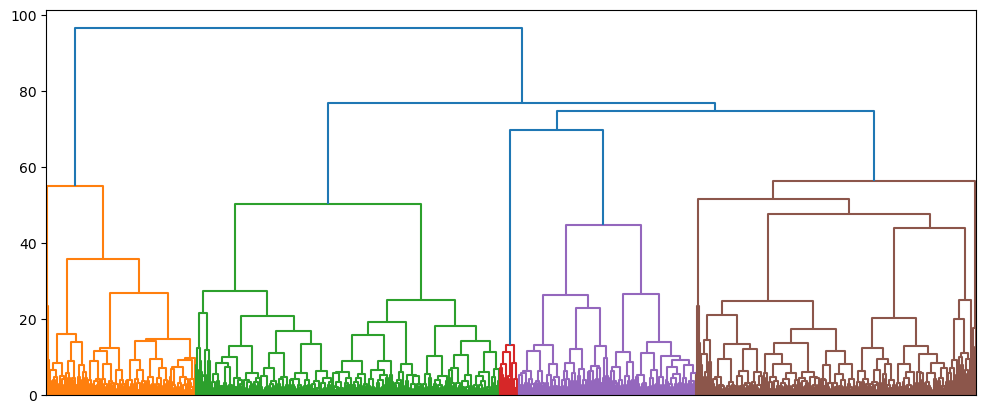

In [14]:
# grouping data based on Ward distance
standard_mergings_ward = linkage(y                = df_prep_sc,
                                 method           = "ward",
                                 optimal_ordering = True)

# setting plot size
fig, ax = plt.subplots(figsize=(12, 5))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation  = 90,
           leaf_font_size = 6,      
           no_labels      = True)


# rendering the plot
plt.show()

From the dendrogram presented, four distinct clusters can be discerned, yet one of these clusters exhibits such pronounced heterogeneity that it warrants further subdivision. This segmentation into five clusters is underpinned by the principle of maximizing intra-cluster similarity while maintaining clear differentiation between clusters. The fifth cluster, which emerges from the bifurcation of the anomalous group, allows for a more granular and insightful categorization of the data, facilitating a nuanced analysis that might otherwise obscure into a broader cluster. The resulting quintuple cluster solution enables a delicate balance between over-segmentation, which can fragment coherent patterns, and under-segmentation, which might mask vital distinctions. Adopting a five-cluster paradigm thus enhances the interpretability and actionable insights derived from the clustering process, as it better captures the underlying structure and dynamics within the data.

In [15]:
# instantiating a k-Means object with five clusters
kmeans = KMeans(n_clusters   = 5,
                n_init       = "auto",
                random_state = 1836)

# fitting the object to the data
kmeans.fit(df_prep_sc)

# converting the clusters to a DataFrame
clusters = pd.DataFrame({"cluster": kmeans.labels_}, index = df_prep_sc.index)

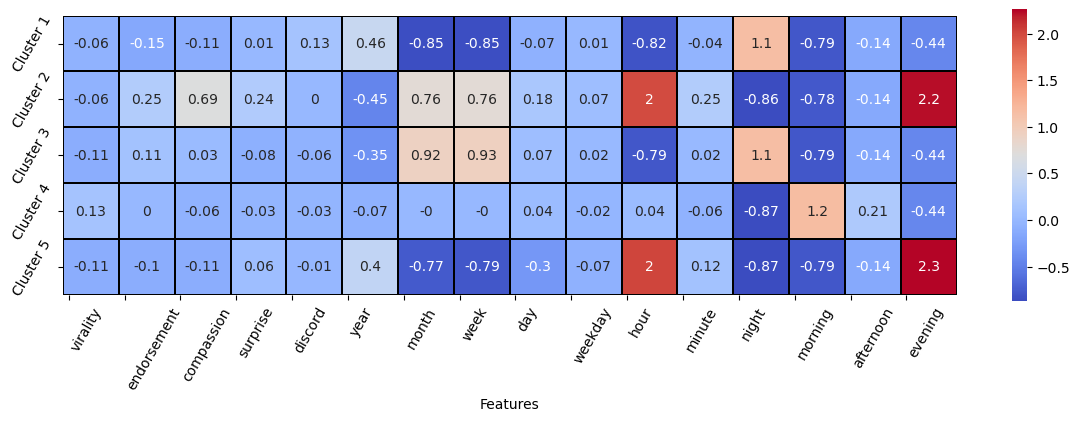

In [16]:
# storing cluster centers
centroids = kmeans.cluster_centers_

# converting cluster centers into a DataFrame
centroids = pd.DataFrame(data = centroids).round(decimals = 2)

# renaming centroid features
centroids.columns = df_prep_sc.columns

# round the values to 2 decimals
rounded_values = centroids.round(2)

# setting plot size
fig, ax = plt.subplots(figsize = (12, 4))

# developing a PC to feature heatmap
sns.heatmap(data       = rounded_values, 
            cmap       = "coolwarm",
            square     = True,
            annot      = True,
            linewidths = 0.1,
            linecolor  = "black")

# setting more plot options
plt.yticks(np.arange(0.5, 5.5, 1),
           ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"],
           rotation = 60,
           ha       = "right")

plt.xticks(np.arange(0.1, 16.1, 1),
           df_prep_sc.columns,
           rotation = 60,
           ha       = "left")

# setting labels
plt.xlabel(xlabel = "Features")

# displaying the plot
plt.tight_layout()
plt.show()

**Cluster 1 - "nocturnal_spring_discord":** This segment's negative values with month and week suggest a spring theme. The positive night association indicates postings during less active hours. The slight positive tilt towards discord could point to occasional controversies. However, the general negative skew towards virality and endorsement indicates posts that fail to capture widespread attention. A "normal" post in this cluster might be a dated promotional update posted at night, with few interactions and low potential for sharing or user advocacy.

**Cluster 2 - "empathetic_evening":** In this cluster, compassion, endorsement, and surprise suggest content that resonates emotionally. It earns user approval, primarily during the evening. Despite the low virality, these posts effectively engage users personally, likely featuring stories or updates that elicit empathy. The high positive value with hour indicates active evening engagement, but the focus here is on depth over breadth of reach. A standard post might be a retailer's story about a day's challenges and achievements, drawing comments and shares from empathetic viewers during their evening browsing.

**Cluster 3 - "nocturnal_winter_endorsement":** The negative emotional engagement with only a positive value with approval indicates content that does not attract much attention. Subsequently, it is often skimmed over. The positive association with night signals posts that fit into users' nighttime activity. The lack of strong positive emotional values indicates a broad appeal without generating deep emotional investment. A "normal" post could be an entertaining fashion tip that receives consistent, albeit moderate, nighttime engagement.

**Cluster 4 - "morning_virality":** Contrasting the other clusters, Cluster 4 has the highest positive value with virality. This indicates that users are more likely to share, perhaps as part of their morning routine. The content is present during the morning hours. It strikes a balance, being neither too emotionally charged nor completely neutral, and fitting well with a morning audience looking for shareable, relevant content to start their day. A typical post here might be a trendy, shareable fashion infographic or a fun, viral challenge encouraging user participation and sharing as part of a morning ritual.

**Cluster 5 - "surprise_evening":** This cluster's moderately strong positive association with surprise suggests content that can elicit unexpected reactions or interest. It is posted in the evening. Despite the negative values across other emotional engagement metrics, the surprise element could indicate posts that intrigue users or provide a break from the norm, suitable for early nighttime engagement. A "normal" post might be an evening teaser for a new product launch or an unusual fashion tip that piques curiosity, leading to more curiosity but not immediate action.

In [17]:
# specifying cluster names
names = {0: "nocturnal_spring_discord",
         1: "empathetic_evening",
         2: "nocturnal_winter_endorsement",
         3: "morning_virality",
         4: "surprise_evening"}

# renaming clusters
clusters.replace(names, inplace = True)

clusters.head(n = 3) # checking results

,cluster
status_id,
1,morning_virality
2,nocturnal_spring_discord
3,nocturnal_spring_discord


In [18]:
# saving dataframe with PCA components, clusters, and original data
model_data = pd.concat([df.status_type,
                        standard_scaler(df[["num_comments", "num_shares",
                                            "num_likes", "num_loves",
                                            "num_wows", "num_hahas",
                                            "num_sads", "num_angrys"]]),
                        df_prep_sc,
                        clusters],
                       axis = 1)

In [19]:
# initialize a list to store the data for each cluster
cluster_data = []

# iterate over each unique cluster name
for cluster_name in model_data["cluster"].unique():
    # calculate the proportion of observations for the current cluster
    proportion = round(len(model_data[model_data["cluster"] == cluster_name])
                       / len(model_data), ndigits = 2)
    
    # get the normalized value counts within the current cluster
    status_counts = model_data.loc[model_data["cluster"] == cluster_name,
                                 "status_type"]\
        .value_counts(normalize = True).round(decimals = 2)
    
    # prepare the status_counts data for inclusion in a DataFrame
    status_counts_data = status_counts.to_dict()
    
    # append the cluster name, its proportion, & the status counts to list
    cluster_data.append({
        "Cluster": cluster_name,
        "Proportion": proportion,
        **status_counts_data  # use ** to unpack the dictionary keys & values
    })

# convert the list of data to a pandas DataFrame
clusters_df = pd.DataFrame(cluster_data)

# display the cluster data
print(clusters_df.to_string(index = False))

                     Cluster  Proportion  photo  video  text
            morning_virality        0.40   0.57   0.38  0.05
    nocturnal_spring_discord        0.22   0.62   0.33  0.05
            surprise_evening        0.09   0.61   0.33  0.06
nocturnal_winter_endorsement        0.22   0.61   0.32  0.06
          empathetic_evening        0.07   0.70   0.20  0.09


The status types within each cluster reveal particular preferences and behaviors associated with video content, among other types of posts, including photos and text.

**Cluster 1 - "nocturnal_spring_discord"** has a moderate proportion of video content at 33%, which is notable considering the cluster's overall lower engagement and nighttime posting characteristics, which suggests that while the videos posted during these hours may not generate virality or strong endorsement, a third of the content is still in video format, which could indicate a strategy targeting users who prefer video content at night, despite the low interaction levels.

**Cluster 2 - "empathetic_evening"** includes video content in 20% of the posts. This lower proportion of video content than photos, which dominate the cluster, implies that the empathetic and personal connection sought in this cluster is more effectively communicated through images rather than videos. However, videos still play a role, offering a deeper narrative that resonates with the evening audience's preference for emotionally engaging content.

**Cluster 3 - "nocturnal_winter_endorsement"** has a slightly higher proportion of video content, at 32%, closely following the dominant photo type. The presence of videos here could indicate content that, while not emotionally charged, offers visual endorsement or approval, such as customer testimonials or product showcases. This aligns with the cluster's theme of broad appeal and consistent nighttime engagement.

**Cluster 4 - morning_virality"**, with the highest proportion of video content at 38%, suggests that video posts are a crucial driver of shareability and engagement in the mornings. The cluster's characteristic of having the highest positive value with virality is related to the engaging and potentially viral nature of video content, which aligns with morning routines where users are likely to share interesting finds.

**Cluster 5 - "surprise_evening"** also has a substantial proportion of video content, 33%, which supports the cluster's theme of eliciting surprise and capturing interest. Videos in this cluster might be geared toward intriguing viewers or revealing something unexpected, which can be a compelling format for early nighttime engagement when users are more likely to be looking for entertainment.

In summary, while photos are the most common status type across all clusters, videos are significant, particularly in clusters 4 and 5, associated with morning virality and evening surprise, respectively. This could suggest a strategic use of video content to leverage its dynamic and engaging nature to boost sharing in the morning and capture interest in the evening.

<h3>Logistic Regression Models</h3>

Before modeling, the data must be preprocessed (scaling has already been executed). This involves converting a categorical variable, which distinguishes content types, into a numerical format that explicitly identifies video content. Subsequently, the initial categorization of content type is removed from the dataset. Moreover, group affiliations, represented by categorical data, are transformed into binary indicators for each unique group, enabling their utilization in cluster modeling (excluding one). Following these modifications, a preview of the initial records is displayed to confirm the adjustments.

In [20]:
# dummy encoding dependent variable and dropping status type
model_data["is_video"] = model_data["status_type"].apply(lambda x: 1 if x == "video" else 0)
model_data.drop("status_type", inplace = True, axis = 1)

# generating dummy variables for clusters
cluster_dummies = pd.get_dummies(model_data["cluster"],
                                 prefix = "cluster").astype(int)

# dropping original clusters and joining the dummy variables
model_data = model_data.drop("cluster", axis = 1).join(cluster_dummies)

model_data.head(n = 3) # checking results

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,virality,endorsement,compassion,surprise,discord,year,month,week,day,weekday,hour,minute,night,morning,afternoon,evening,is_video,cluster_empathetic_evening,cluster_morning_virality,cluster_nocturnal_spring_discord,cluster_nocturnal_winter_endorsement,cluster_surprise_evening
status_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.395884,1.774427,0.470958,1.959547,0.148745,0.128753,0.433626,-0.180743,1.205923,-0.115982,-0.058512,0.380518,-0.865707,0.830746,-0.703235,-0.669992,0.716105,1.473608,-0.265419,-1.588118,-0.872641,1.268947,-0.14453,-0.443119,1,0,1,0,0,0
2,-0.264694,-0.311409,-0.039781,-0.100421,-0.146815,-0.214739,-0.145130,-0.180743,-0.239104,-0.327559,-0.218049,0.192075,0.124099,0.830746,-0.703235,-0.669992,0.258936,-0.493486,-0.691660,-0.343098,1.145946,-0.788055,-0.14453,-0.443119,0,0,0,1,0,0
3,0.527483,0.261798,0.439596,1.413531,0.838387,0.472246,-0.145130,5.234481,1.812909,0.087577,-0.418553,-1.116267,4.352389,0.830746,-0.703235,-0.669992,0.258936,-0.493486,-1.117901,-0.229915,1.145946,-0.788055,-0.14453,-0.443119,1,0,0,1,0,0


Before models are developed, functions are created to facilitate this process.

In [21]:
# creating a results list
model_results = pd.DataFrame([], columns =
                     ["Model Name", "train_RSQ", "test_RSQ", "tt_gap",
                     "AUC Score", "Precision", "Sensitivity", "Specificity",
                     "True no_video",  # True Negatives
                     "False is_video", # False Positives
                     "False no_video", # False Negatives
                     "True is_video"]) # True Positives


# creating a modeling function
def model(x_features,                   # independent variable dictionary
          y_feature,                    # dependent variable
          model,                        # model to be used
          name,                         # name to identify model better
          thresh             = None,    # threshold to change predictions to 1
          thresh_results     = False,   # printing value counts of probs
          coeff              = False,   # printing coefficients
          cm                 = False,): # printing confusion matrix
    """
    Executes specified regression model on training data, evaluates its
    performance, and optionally generates various outputs.

    Parameters:
    - x_features: [str]
        Independent variables dictionary to specify data to be used.
    - y_feature: str
        Dependent variable to specify data to be used.
    - model: estimator object (regression model to use)
        This should be a scikit-learn-like model that
        has .fit(), .predict(), and .score() methods.
    - name: str
        Name of the regression model for identification in outputs.
    - thresh: float, optional (default = None)
        Threshold to change predictions to 1.
    - thresh_results: bool, optional (default = False)
        If True, prints propabilities of low_bwght.
    - coeff: bool, optional (default = False)
        If True, prints the model's coefficients.
        Not applicable for models without .coef_ attribute.
    - cm: bool, optional (default = False)
        If True, print confusion matrix.

    Requires:
    - Variables model_data and model_results must be predefined in the global
      calling environment.
    - The pandas, numpy, matplotlib.pyplot, and seaborn libraries for
      data manipulation and plotting.
    """
    global model_data, model_results
    
    # selecting data
    x_data = model_data[x_features]
    y_data = model_data[y_feature]
    
    # train-test split (to validate the model)
    x_train, x_test, y_train, y_test = train_test_split(
        x_data,                # as selected
        y_data,                # as selected
        test_size    = 0.25,   # sample split size
        random_state = 1836,   # ensures reproducability
        stratify     = y_data) # preserving balance in dependent variable
    
    ## Applying Model ########################################################        
    model_fit = model.fit(x_train, y_train)         # fitting training data
    model_pred = model.predict(x_test)              # predicting data

    if thresh is not None:
        # Get the predicted probabilities for the positive class
        model_pred_proba = model.predict_proba(x_test)[:, 1]
        
        # Apply threshold to determine class labels
        model_pred = (model_pred_proba >= thresh).astype(int)
        
    # scoring results
    model_train_score = model.score(x_train, y_train).round(decimals = 4)
    model_test_score  = model.score(x_test, y_test).round(decimals = 4)
    model_gap         = abs(model_train_score - model_test_score).round(decimals = 4)
    
    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true = y_test,
                                      y_pred = model_pred).ravel()
    
    # preparing AUC, precision, and recall
    auc            = roc_auc_score(y_true   = y_test,     # auc
                                   y_score  = model_pred).round(decimals = 4)
    accuracy       = accuracy_score(y_true  = y_test,     # accuracy
                                    y_pred  = model_pred).round(decimals = 4)
    precision      = precision_score(y_true = y_test,     # precision
                                     y_pred = model_pred).round(decimals = 4)
    recall         = recall_score(y_true    = y_test,     # sensitivity
                                  y_pred    = model_pred).round(decimals = 4)
    specificity    = (tn / (tn + fp)).round(decimals = 4) # specificity


    # dynamically printing model summary and metrics
    thresh_display = thresh if thresh is not None else 0.5
    print(f"""\
    Model Name:     {name} with threshold {thresh_display}
    Train Score:    {model_train_score}
    Test Score:     {model_test_score}
    Train-Test Gap: {model_gap}
    
    AUC:                              {auc}
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): {accuracy}
    Precision (TP/(TP+FP)):           {precision}
    Recall/Sensitivity (TP/(TP+FN)):  {recall}
    Specificity (TN/(TN+FP)):         {specificity}""")  
    
    ## Coefficients ##########################################################    
    if coeff == True: # printing coefficients
        # zipping each feature name to its coefficient
        model_coefficients = zip(x_data.columns,
                                 model.coef_.ravel().round(decimals = 2))
        
        # setting up a placeholder list to store model features
        # If model.intercept_ is an array, access the first element;
        # otherwise, use it directly
        intercept_value = model.intercept_[0] if hasattr(model.intercept_,
                                     "__getitem__") else model.intercept_
        coefficient_lst = [("intercept", round(intercept_value, ndigits = 2))]
        
        # printing out each feature-coefficient pair one by one
        for coefficient in model_coefficients:
            coefficient_lst.append(coefficient)
        
        print(f"""\nCoefficents
---------------------------------------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}""")
        
    ## Model Results #########################################################
    # instantiating a list to store model results
    results_new = [name, model_train_score, model_test_score, model_gap,
                   auc, precision, recall, specificity, tn, fp, fn, tp]
       
    # converting to DataFrame
    results_new = pd.DataFrame(data = results_new)

    # transposing (rotating) DataFrame
    results_new = np.transpose(results_new)

    # adding column names
    model_columns = ["Model Name", "train_RSQ", "test_RSQ", "tt_gap",
                     "AUC Score", "Precision", "Sensitivity", "Specificity",
                     "True no_video",    # True Negatives
                     "False is_video", # False Positives
                     "False no_video",   # False Negatives
                     "True is_video"]  # True Positives

    results_new.columns = model_columns

    # concatenating to model_results
    model_results = pd.concat(objs = [model_results, results_new],
                              axis = 0, ignore_index = True)
    
    ## Thresh Results ########################################################
    if thresh_results == True:
        if thresh is not None:
            # Converting probabilities to a pandas Series
            prob_series = pd.Series(model_pred_proba)

            # Counting occurrences of each unique probability and sorting
            value_counts_sorted = prob_series.value_counts().sort_index()
            print("\nHere are the predicted probabilities of is_video:")
            print(value_counts_sorted)
    
    ## Printing Confusion Matrix #############################################
    if cm == True:
        # Determine the maximum width needed to ensure alignment
        max_num_width = max(len(str(tn)), len(str(fp)), len(str(fn)), len(str(tp)))
        
        # Use formatted string literals to print confusion matrix
        print(f"""\n
Confusion Matrix
----------------
  
True Negatives (correct) {tn:<{max_num_width}}     | False Positives (incorrect) {fp:<{max_num_width}}
PREDICTED: NO VIDEO (is_video=0) | PREDICTED: VIDEO    (is_video=1)
ACTUAL:    NO VIDEO (is_video=0) | ACTUAL:    NO VIDEO (is_video=0)
---------------------------------|---------------------------------
False Negatives (incorrect) {fn:<{max_num_width}}  | True Positives (correct) {tp:<{max_num_width}}
PREDICTED: NO VIDEO (is_video=0) | PREDICTED: VIDEO    (is_video=1)
ACTUAL:    VIDEO    (is_video=1) | ACTUAL:    VIDEO    (is_video=1)""")
  
    
def tune_and_display_results(x_features, # independent variables
                             y_feature,  # dependent variable
                             model,      # model to be used
                             name,       # name to be used
                             parameters, # parameter grid                             
                             n = 3):
    """
    Performs hyperparameter tuning on a specified machine learning model
    using RandomizedSearchCV, which displays the top n tuning results
    in a structured format.

    Parameters:
    - x_features: [str]
        Independent variables dictionary to specify data to be used.
    - y_feature: str
        Dependent variable to specify data to be used.
    - model: estimator object (regression model to use)
        This should be a scikit-learn-like model that
        has .fit(), .predict(), and .score() methods.
    - name: str
        Name of the regression model for identification in outputs.
    - parameters: A dictionary specifying the parameter grid for tuning.
    - n: An integer specifying the number of top n results to display.

    The function splits the dataset into training and testing sets, performs
    hyperparameter tuning to find the best parameters for the given model,
    and then processes the tuning results to display the top n configurations.
    The results include the rank, mean test score, standard deviation of the
    test score, and all the parameters tested in a pandas DataFrame.
    
    Returns:
    - A pandas DataFrame containing the top n tuning results
      with parameters in separate columns.
    """
    global model_data
    
    # selecting data
    x_data = model_data[x_features]
    y_data = model_data[y_feature]
    
    # Splitting the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = 0.25,
                                                        random_state = 1836)

    # Setting up and fitting the RandomizedSearchCV
    tuned_model_cv = RandomizedSearchCV(estimator           = model,
                                        param_distributions = parameters,
                                        random_state        = 1836,
                                        cv                  = 5,
                                        n_iter              = 100,
                                        scoring = make_scorer(roc_auc_score,
                                            needs_threshold = False))
    tuned_model_cv.fit(x_data, y_data)

    # Displaying the best score achieved during tuning
    print(f"\nTop Tuned {name} Score: {tuned_model_cv.best_score_.round(4)}")

    # Processing and displaying the tuning results
    cv_results = tuned_model_cv.cv_results_
    rows_list = []

    # Extracting the relevant data
    for rank, params, mean_score, std_score in zip(cv_results["rank_test_score"],
                                                   cv_results["params"],
                                                   cv_results["mean_test_score"],
                                                   cv_results["std_test_score"]):
        row = params.copy() # parameter settings as initial key-value pairs
        row.update({"Model_Rank": rank,
                    "Mean_Test_Score": mean_score,
                    "SD_Test_Score": std_score}) # loading in data
        rows_list.append(row)                    # storing data

    # Sorting and filtering the top n tuned results
    results_df = pd.DataFrame(rows_list).sort_values(by = "Model_Rank").head(n = n)

    # Adding parameter column names
    cols = ["Model_Rank", "Mean_Test_Score", "SD_Test_Score"] + \
           [col for col in results_df if col not in ["Model_Rank",
                                                     "Mean_Test_Score",
                                                     "SD_Test_Score"]]
    # Filtering and returning relevant output
    results_df = results_df[cols]
    return results_df

First, a hyperparameterized model is created with all existing x-features:

In [22]:
# with original features
param_grid_lr = {     
    "penalty": ["l1", "l2"]              # penalty types
    ,"max_iter": np.arange(100, 1000, 1) # iterations for convergence
    ,"fit_intercept": [True, False]      # intercept existance
    ,"C": np.logspace(-4, 4, 20)}        # regularization strength

# Applying tuning function
tune_and_display_results(
    # selecting x features
    x_features = ["num_comments", "num_shares", "num_likes", "num_loves",
                  "num_wows", "num_hahas", "num_sads", "num_angrys",
                  "year", "month", "week", "day", "weekday", "hour",
                  "minute", "night", "morning", "afternoon", "evening"],
    
    # selecting y feature
    y_feature = "is_video",
    
    model = LogisticRegression(
        # fixed parameters
        random_state  = 1836
        ,class_weight = "balanced"
        ,solver       = "liblinear"
        
    ),name      = "Logistic Regression with Original Features" # model
    ,parameters = param_grid_lr         # grid of parameters to tune
    ,n          = 3)                    # output of n best models


Top Tuned Logistic Regression with Original Features Score: 0.7157


,Model_Rank,Mean_Test_Score,SD_Test_Score,penalty,max_iter,fit_intercept,C
55,1,0.715712,0.096250,l2,495,False,0.233572
33,1,0.715712,0.096250,l2,134,False,0.233572
97,3,0.715130,0.097897,l1,263,False,0.088587


In [23]:
model(x_features = ["num_comments", "num_shares", "num_likes", "num_loves",
                    "num_wows", "num_hahas", "num_sads", "num_angrys",
                    "year", "month", "week", "day", "weekday", "hour",
                    "minute", "night", "morning", "afternoon", "evening"],
      y_feature = "is_video",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "liblinear"
          
          # hypertuned parameters
          ,penalty           = "l2"
          ,max_iter          = 495
          ,fit_intercept     = False
          ,C                 = 0.233572
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression with Original Features",
      thresh         = None,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = False, # coefficient display option 
      cm             = False) # confusion matrix display option         

    Model Name:     Logistic Regression with Original Features with threshold 0.5
    Train Score:    0.813
    Test Score:     0.7983
    Train-Test Gap: 0.0147
    
    AUC:                              0.7076
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.7983
    Precision (TP/(TP+FP)):           0.954
    Recall/Sensitivity (TP/(TP+FN)):  0.4256
    Specificity (TN/(TN+FP)):         0.9895


Second, a hyperparameterized model is created with all retained principal components:

In [24]:
# with principal components
param_grid_lr = {     
    "penalty": ["l1", "l2"]              # penalty types
    ,"max_iter": np.arange(100, 1000, 1) # iterations for convergence
    ,"fit_intercept": [True, False]      # intercept existance
    ,"C": np.logspace(-4, 4, 20)}        # regularization strength

# Applying tuning function
tune_and_display_results(
    # selecting x features
    x_features = ["virality", "endorsement", "compassion",
                  "surprise", "discord"],
    
    # selecting y feature
    y_feature = "is_video",
    
    model = LogisticRegression(
        # fixed parameters
        random_state  = 1836
        ,class_weight = "balanced"
        ,solver       = "liblinear"
        
    ),name      = "Logistic Regression with Principal Components" # model
    ,parameters = param_grid_lr         # grid of parameters to tune
    ,n          = 3)                    # output of n best models


Top Tuned Logistic Regression with Principal Components Score: 0.7194


,Model_Rank,Mean_Test_Score,SD_Test_Score,penalty,max_iter,fit_intercept,C
9,1,0.719432,0.089008,l2,851,False,0.004833
83,2,0.719227,0.092569,l2,101,False,0.033598
11,2,0.719227,0.092569,l2,442,False,0.033598


In [25]:
model(x_features = ["virality", "endorsement", "compassion",
                  "surprise", "discord"],
      y_feature = "is_video",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "liblinear"
          
          # hypertuned parameters
          ,penalty           = "l2"
          ,max_iter          = 851
          ,fit_intercept     = False
          ,C                 = 0.004833
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression with Principal Components",
      thresh         = None,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = False, # coefficient display option 
      cm             = False) # confusion matrix display option         

    Model Name:     Logistic Regression with Principal Components with threshold 0.5
    Train Score:    0.8078
    Test Score:     0.7896
    Train-Test Gap: 0.0182
    
    AUC:                              0.6997
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.7896
    Precision (TP/(TP+FP)):           0.9111
    Recall/Sensitivity (TP/(TP+FN)):  0.4205
    Specificity (TN/(TN+FP)):         0.9789


Third, a hyperparameterized model is created with all retained clusters, where the cluster_empathetic_evening is omitted and thus serves as a basis:

In [26]:
# with clusters
param_grid_lr = {     
    "penalty": ["l1", "l2"]              # penalty types
    ,"max_iter": np.arange(100, 1000, 1) # iterations for convergence
    ,"fit_intercept": [True, False]      # intercept existance
    ,"C": np.logspace(-4, 4, 20)}        # regularization strength

# Applying tuning function
tune_and_display_results(
    # selecting x features
    x_features = [# "cluster_empathetic_evening", omitted as base
                  "cluster_morning_virality",
                  "cluster_nocturnal_spring_discord",
                  "cluster_nocturnal_winter_endorsement",
                  "cluster_surprise_evening"],
    
    # selecting y feature
    y_feature = "is_video",
    
    model = LogisticRegression(
        # fixed parameters
        random_state  = 1836
        ,class_weight = "balanced"
        ,solver       = "liblinear"
        
    ),name      = "Logistic Regression with Clusters" # model
    ,parameters = param_grid_lr         # grid of parameters to tune
    ,n          = 3)                    # output of n best models


Top Tuned Logistic Regression with Clusters Score: 0.5067


,Model_Rank,Mean_Test_Score,SD_Test_Score,penalty,max_iter,fit_intercept,C
97,1,0.506694,0.065401,l1,263,False,0.088587
62,1,0.506694,0.065401,l1,531,False,0.088587
0,3,0.500000,0.000000,l1,113,False,0.001833


In [27]:
model(x_features = [# "cluster_empathetic_evening", omitted as base
                  "cluster_morning_virality",
                  "cluster_nocturnal_spring_discord",
                  "cluster_nocturnal_winter_endorsement",
                  "cluster_surprise_evening"],
      y_feature = "is_video",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "liblinear"
          
          # hypertuned parameters
          ,penalty           = "l1"
          ,max_iter          = 263
          ,fit_intercept     = False
          ,C                 = 0.088587
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression with Clusters",
      thresh         = None,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = False, # coefficient display option 
      cm             = False) # confusion matrix display option         

    Model Name:     Logistic Regression with Clusters with threshold 0.5
    Train Score:    0.5656
    Test Score:     0.5548
    Train-Test Gap: 0.0108
    
    AUC:                              0.5246
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.5548
    Precision (TP/(TP+FP)):           0.3668
    Recall/Sensitivity (TP/(TP+FN)):  0.4308
    Specificity (TN/(TN+FP)):         0.6184


<h3>Model Selection</h3>

In [28]:
# showing all model results
model_results

,Model Name,train_RSQ,test_RSQ,tt_gap,AUC Score,Precision,Sensitivity,Specificity,True no_video,False is_video,False no_video,True is_video
0,Logistic Regression with Original Features,0.813,0.7983,0.0147,0.7076,0.954,0.4256,0.9895,376,4,112,83
1,Logistic Regression with Principal Components,0.8078,0.7896,0.0182,0.6997,0.9111,0.4205,0.9789,372,8,113,82
2,Logistic Regression with Clusters,0.5656,0.5548,0.0108,0.5246,0.3668,0.4308,0.6184,235,145,111,84


Among the three evaluated logistic regression models, the one employing principal components analysis (PCA) is selected as the most effective, primarily due to its proficient balance between predictive accuracy and model simplicity. This model showcases a robust generalization capability, evidenced by its closely aligned training and testing values (0.8078 and 0.7896, respectively) and a modest training-testing performance gap (0.0182), indicating minimal overfitting. The AUC score of 0.6997 signifies its adequate discriminatory power between classes. Precision is notably high at 0.9111, suggesting that the model is highly reliable in its positive class predictions. The sensitivity and specificity metrics further attest to its balanced performance in identifying both classes accurately. Crucially, the model derived from principal components is preferred over the variant with all original features due to its streamlined complexity and enhanced interpretability; reducing the feature space through PCA mitigates the risk of model overfitting and simplifies the interpretation of results without substantially compromising predictive power. The logistic regression model with original features, while demonstrating slightly better raw performance metrics, is ultimately set aside because the complexity and potential for overinterpretation it introduces outweigh the marginal gains in accuracy, making the PCA-based model the superior choice for both practical application and theoretical analysis. The regression with clusters can be neglected due to significantly worse AUC and precision scores.

In [29]:
model(x_features = ["virality", "endorsement", "compassion",
                  "surprise", "discord"],
      y_feature = "is_video",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "liblinear"
          
          # hypertuned parameters
          ,penalty           = "l2"
          ,max_iter          = 851
          ,fit_intercept     = False
          ,C                 = 0.004833
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression with Principal Components",
      thresh         = None,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = True, # coefficient display option 
      cm             = True) # confusion matrix display option         

    Model Name:     Logistic Regression with Principal Components with threshold 0.5
    Train Score:    0.8078
    Test Score:     0.7896
    Train-Test Gap: 0.0182
    
    AUC:                              0.6997
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.7896
    Precision (TP/(TP+FP)):           0.9111
    Recall/Sensitivity (TP/(TP+FN)):  0.4205
    Specificity (TN/(TN+FP)):         0.9789

Coefficents
---------------------------------------
       Feature  Coefficient
0    intercept         0.00
1     virality         0.63
2  endorsement        -0.18
3   compassion         0.01
4     surprise        -0.15
5      discord        -0.21


Confusion Matrix
----------------
  
True Negatives (correct) 372     | False Positives (incorrect) 8  
PREDICTED: NO VIDEO (is_video=0) | PREDICTED: VIDEO    (is_video=1)
ACTUAL:    NO VIDEO (is_video=0) | ACTUAL:    NO VIDEO (is_video=0)
---------------------------------|---------------------------------
False Negatives (incorrect) 113  | True Posit

The virality coefficient in the logistic regression model utilizing principal components is 0.63, indicating a strong positive relationship, suggesting that as the virality score increases, so does the likelihood of the post being a video, implying that viral content tends to be video-based, which is a valuable insight for content creators seeking to boost engagement. Conversely, the coefficients for endorsement, surprise, and discord (at -0.18, -0.15, and -0.21, respectively) show negative relationships, indicating that increases in these attributes decrease the likelihood of a post being a video, highlighting the complex interplay between content characteristics and their formats. The near-zero coefficient for compassion indicates a minimal impact on the likelihood of a post being a video. It suggests that emotional appeal through compassion does not significantly set video content apart from other types in this model's context.

The confusion matrix produced by this model provides essential insights into its performance and potential implications for decision-making. It records 372 true negatives (correctly identified non-videos) and 82 true positives (correctly identified videos), demonstrating the model's solid capability to identify video and non-video posts accurately. However, eight false positives and 113 false negatives point to significant areas of concern. The false positives, though relatively few, indicate that the model sometimes incorrectly classifies non-video posts as videos, potentially leading to inappropriate adjustments in content strategy and diverting resources toward video production where it might not be as effective. More critically, the 113 false negatives represent a significant challenge by overlooking video content, which could result in missed opportunities to leverage the engagement potential of videos, emphasizing the need for continuous evaluation and adjustment of the model, especially in the rapidly evolving environment of social media, where content trends and user behaviors change quickly.

Comprehending the implications of these coefficients and the confusion matrix is vital for business owners to make informed decisions. The model's ability to accurately identify non-video content and its challenges with false negatives in video prediction necessitates a balanced content strategy. This strategy should leverage insights from the model while remaining adaptable to its limitations. Optimizing the content mix based on these findings could improve engagement and reach, aligning marketing efforts with consumer preferences and behaviors in the digital landscape.

~~~                            
 ______   __   ____ _        ___        _____ _____ ____  _____      /_  __
| __ ) \ / /  / ___| |      / \ \      / /_ _| ____/ ___|| ____|    (_)  | \
|  _ \\ V /  | |   | |     / _ \ \ /\ / / | ||  _| \___ \|  _|       _   | |
| |_) || |   | |___| |___ / ___ \ V  V /  | || |___ ___) | |___     ( )  | |
|____/ |_|    \____|_____/_/   \_\_/\_/  |___|_____|____/|_____|    |/  /_/ 
                                                                
~~~

<br>